# Исследование влияния погодных условий на качество воздуха

В данной работе я пытаюсь понять, насколько качество воздуха зависит от погодных условий. Часто в дискуссиях о промышленной и экологической политике указывается на промышленное производство, как на основной фактор загрязнения городов. Я же хочу обратить внимание на другие факторы, влияющие на качество воздуха.
Для того, чтобы получить данные о качестве воздуха в крупнейших городах мира я пропарсил таблицу с данными об AQI(air quality index) c сайтa Красного Креста.("https://www.iqair.com/world-air-quality-ranking")
 Данные о погоде я брал из открытой базы данных на kaggle (https://www.kaggle.com/datasets/nelgiriyewithana/global-weather-repository)

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

#запарсим таблицу с данными о качестве воздуха с сайта красного креста
def get_air_quality_data():
    # Настройка драйвера с использованием webdriver_manager
    service = Service(ChromeDriverManager().install())
    options = webdriver.ChromeOptions()
    options.headless = True  # Запуск в фоновом режиме
    driver = webdriver.Chrome(service=service, options=options)


    url = "https://www.iqair.com/world-air-quality-ranking"

    # Открытие страницы
    driver.get(url)

    try:
        # Ожидание загрузки таблицы
        WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.TAG_NAME, 'table'))
        )

        # Извлечение HTML-кода страницы
        soup = BeautifulSoup(driver.page_source, 'html.parser')

        # Находим таблицу по тегу <table>
        table = soup.find('table')

 
        headers = []
        rows = []

        if table:
            # Извлекаем заголовки таблицы
            thead = table.find('thead')
            if thead:
                headers = [th.text.strip() for th in thead.find_all('th')]

            # Извлекаем строки таблицы
            tbody = table.find('tbody')
            if tbody:
                for tr in tbody.find_all('tr'):
                    cells = [td.text.strip() for td in tr.find_all('td')]
                    rows.append(cells)

           
            if headers and len(rows) > 0 and len(headers) != len(rows[0]):
                headers = [f'Column {i}' for i in range(1, len(rows[0]) + 1)]

            
            df = pd.DataFrame(rows, columns=headers)

            return df
       
    finally:
        driver.quit()


df = get_air_quality_data()


In [163]:
#разделяем столбец со страной и городом на 2 отдельных
split_columns = df.iloc[:, 2].str.split(',', expand=True)
if split_columns.shape[1] < 2:
    split_columns[1] = None


df['city'] = split_columns[0]
df['country'] = split_columns[1]

df.drop(df.columns[2], axis=1, inplace=True)

In [164]:
#удаляем ненужные столбцы
del df['Column 5']
del df['Column 1']
del df['Column 2']

In [166]:
df

,Column 4,city,country
0,174,Jakarta,Indonesia
1,168,Delhi,India
2,153,Manama,Bahrain
3,144,Medan,Indonesia
4,139,Kinshasa,Democratic Republic of the Congo
...,...,...,...
113,15,Portland,USA
114,12,Dublin,Ireland
115,11,Bangkok,Thailand
116,1,Auckland,New Zealand


In [168]:
#меняем названия  столбцов и индексов, чтобы потом удобно было добавить другие данные
df=df.set_index('city')

df.rename(columns={'Column 4': 'AQI'}, inplace=True)


,AQI,country
city,,
Jakarta,174,Indonesia
Delhi,168,India
Manama,153,Bahrain
Medan,144,Indonesia
Kinshasa,139,Democratic Republic of the Congo
...,...,...
Portland,15,USA
Dublin,12,Ireland
Bangkok,11,Thailand


Используем данные о погоде с августа 2023 года по сегодняшний день из открытой базы данных на kaggle
https://www.kaggle.com/datasets/nelgiriyewithana/global-weather-repository

In [169]:
weather=pd.read_csv('GlobalWeatherRepository.csv')
factors=weather[['location_name','temperature_celsius','wind_mph','pressure_mb','humidity']]
factors=factors.rename(columns = {'location_name':'city'} )
factors=factors.set_index('city')
factors=factors.groupby(factors.index).mean() #группируем и заменяем все повторяющиеся города на их среднее
# чтобы получить средние значения показателей за все время


In [170]:
final = factors.merge(df,on='city',how='inner') #объединяем данные о погоде и данные о качестве воздуха 
del final['country']

## для определения влияния различных погодных факторов на качество воздуха посчитаем попарные корреляции

In [172]:
#посчитаем корреляции между индексом качества воздуха и остальными 4 показателями
correlations = final.corr()['AQI'].drop('AQI')


print("Попарные корреляции с AQI:")
print(correlations)

Попарные корреляции с AQI:
temperature_celsius    0.497416
wind_mph              -0.180323
pressure_mb           -0.408614
humidity              -0.053070
Name: AQI, dtype: float64


# также для наглядности построим линейные регрессии AQI по 4 показателям

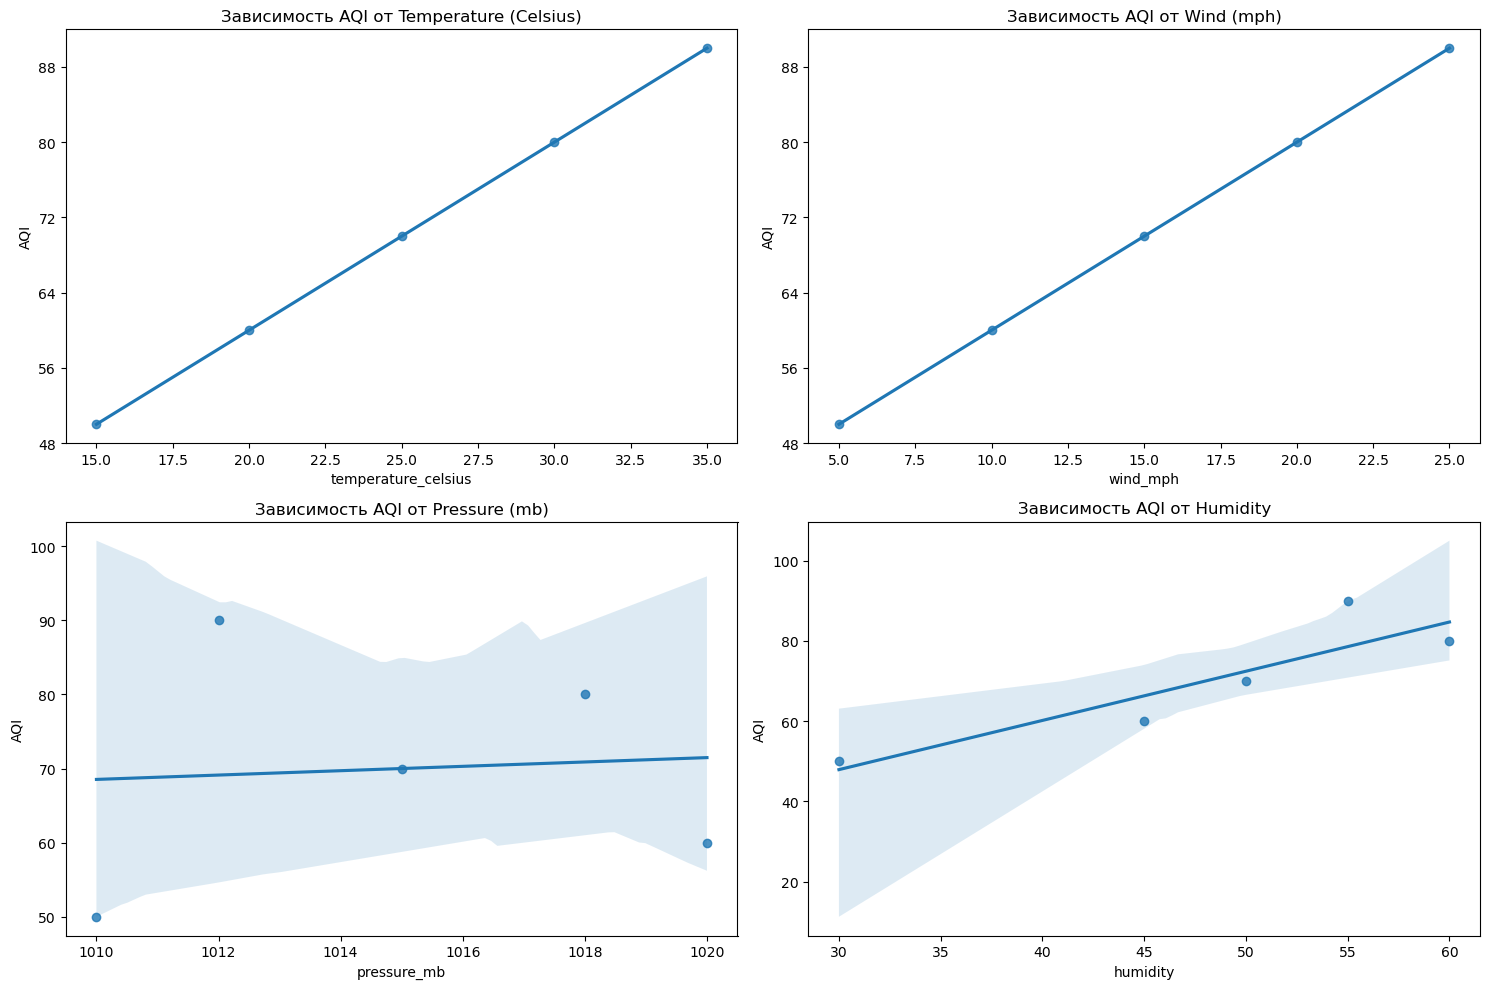

In [178]:

# Построим графики зависимости AQI от остальных показателей и добавим линейные регрессии
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

sns.regplot(data=final, x='температура(по цельсию)', y='AQI', ax=axs[0, 0])
axs[0, 0].set_title('Зависимость AQI от температуры')
axs[0, 0].yaxis.set_major_locator(MaxNLocator(nbins=6))

sns.regplot(data=final, x='скорость ветра(м/ч)', y='AQI', ax=axs[0, 1])
axs[0, 1].set_title('Зависимость AQI от скорости ветра')
axs[0, 1].yaxis.set_major_locator(MaxNLocator(nbins=6))

sns.regplot(data=final, x='давление(мм)', y='AQI', ax=axs[1, 0])
axs[1, 0].set_title('Зависимость AQI от давления')
axs[1, 0].yaxis.set_major_locator(MaxNLocator(nbins=6))

sns.regplot(data=final, x='влажность', y='AQI', ax=axs[1, 1])
axs[1, 1].set_title('Зависимость AQI от влажности')
axs[1, 1].yaxis.set_major_locator(MaxNLocator(nbins=6))

plt.tight_layout()
plt.show()

в результате видим, что есть положительная связь между уровнем загрязнения и температурой и отрицательная связь между уровнем загрязнения и давлением. Корреляция между AQI и двумя другими показателями близка к 0